## Data Preparation

In [336]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import unidecode
import nltk
import re

# Initialisation des outils de prétraitement
stop_words = set(stopwords.words('french'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Fonction de prétraitement des données
def preprocess(text):
    text = unidecode.unidecode(text) # Suppression des accents
    text = re.sub(r'[^\w\s]', '', text) # Suppression des caractères spéciaux
    text = text.lower() # Conversion en minuscules

    tokens = nltk.word_tokenize(text) # Tokenisation
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens] # Lemmatisation
    stemmed_tokens = [stemmer.stem(token) for token in lemmatized_tokens] # Stemming
    cleaned_tokens = [token for token in stemmed_tokens if token not in stop_words] # Suppression des mots vides
    
    text = ' '.join(cleaned_tokens) # Réassemblage du texte pré-traité
    return text

In [370]:
import numpy as np
import json

# Chargement des données à partir du fichier JSON
with open('donnees_clusterisees.json', 'r') as f:
    data = json.load(f)
    
# On evite d'importer les données mal etiquete
data = [d for d in data if d['label'] not in [3]]
labels = [d['label'] for d in data if d['label'] not in [3]]

# Extraction de la colonne "name" et "description"
names = [d['name'] for d in data]
cleaned_names = [preprocess(name) for name in names]

# # handle missing keys using an empty string as the default value
# descriptions = [d.get('precision_on_the_protection', '') for d in data]
# cleaned_descriptions = [preprocess(description) for description in descriptions]
# historiques = [d.get('historique', '') for d in data]
# cleaned_historiques = [preprocess(historique) for historique in historiques]

# combined_data = [name + ' ' + description + ' ' + historique for name, description, historique in zip(cleaned_names, cleaned_descriptions, cleaned_historiques)]

## Learning

### Train different models
---
Let's start by splitting the data into a training sample and a test sample

In [338]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

DEFAULT_CV = 10
X_train, X_test, Y_train, Y_test = train_test_split(cleaned_names, labels, test_size=0.7)

# Fit and transform the CountVectorizer on your training data
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)

# Transform the test data using CountVectorizer object
X_test = vectorizer.transform(X_test)

#### K-nearest neighbors

In [339]:
from sklearn.neighbors import KNeighborsClassifier

def trainWithKNNClassifier(neighbors_range):
    # Store the scores
    cv_scores = []
    
    # Loop over the hyperparameter values
    for k in neighbors_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=DEFAULT_CV)
        cv_scores.append(scores.mean())

    # Find the best hyperparameter with the highest score
    best_k = neighbors_range[cv_scores.index(max(cv_scores))]
    best_score = max(cv_scores)
  
    # Calculate 95% confidence interval for the best score
    std_error = np.std(cv_scores) / np.sqrt(3)
    lower_bound = best_score - 1.96 * std_error
    upper_bound = best_score + 1.96 * std_error
    
    return cv_scores, best_k, best_score, lower_bound, upper_bound

#### Decision trees (max_depth)

In [340]:
from sklearn.tree import DecisionTreeClassifier

def trainWithDecisionTreeClassifier(depth_range):

    # Create an empty list to store the cross-validation scores for each hyperparameter value
    cv_scores = []

    # Loop over the hyperparameter values and compute the cross-validation score for each
    for depth in depth_range:
        dt = DecisionTreeClassifier(max_depth=depth)
        scores = cross_val_score(dt, X_train, Y_train, cv=10)
        cv_scores.append(np.mean(scores))

    # Find the best hyperparameter value with the highest cross-validation score
    best_depth = depth_range[np.argmax(cv_scores)]
    best_score = max(cv_scores)

    # Calculate the 95% confidence interval for the best score
    std_error = np.std(cv_scores) / np.sqrt(10)
    lower_bound = best_score - 1.96 * std_error
    upper_bound = best_score + 1.96 * std_error

    return cv_scores, best_depth, best_score, lower_bound, upper_bound

#### Perceptron linéaire

In [341]:
from sklearn.linear_model import Perceptron

def trainWithPerceptron(max_iters):
    # Create an empty list to store the cross-validation scores for each hyperparameter value
    cv_scores = []

    # Loop over the hyperparameter values and compute the cross-validation score for each
    for max_iter in max_iters:
        perceptron = Perceptron(max_iter=max_iter)
        scores = cross_val_score(perceptron, X_train, Y_train, cv=DEFAULT_CV)
        cv_scores.append(scores.mean())

    # Find the best hyperparameter value with the highest cross-validation score
    best_max_iter = max_iters[cv_scores.index(max(cv_scores))]
    best_score = max(cv_scores)

    # Calculate the 95% confidence interval of the cross-validation scores
    std_err = np.std(cv_scores) / np.sqrt(10)
    lower_bound = best_score - 1.96 * std_err
    upper_bound = best_score + 1.96 * std_err

    return cv_scores, best_max_iter, best_score, lower_bound, upper_bound

#### SVC Gaussian

In [342]:
from sklearn.svm import SVC

def trainWithSVCGaussian(gammas):
    # Create an empty list to store the cross-validation scores for each hyperparameter value
    cv_scores = []

    # Loop over the hyperparameter values and compute the cross-validation score for each
    for gamma in gammas:
        svm = SVC(kernel='rbf', gamma=gamma)
        scores = cross_val_score(svm, X_train, Y_train, cv=DEFAULT_CV)
        cv_scores.append(scores.mean())

    # Find the best hyperparameter value with the highest cross-validation score
    best_gamma = gammas[cv_scores.index(max(cv_scores))]
    best_score = max(cv_scores)

    # Calculate the 95% confidence interval of the cross-validation scores
    std_err = np.std(cv_scores) / np.sqrt(10)
    lower_bound = best_score - 1.96 * std_err
    upper_bound = best_score + 1.96 * std_err

    return cv_scores, best_gamma, best_score, lower_bound, upper_bound

#### SVC Polynomial

In [343]:
from sklearn.svm import SVC

def trainWithSVCPolynomial(degrees):
    # Create an empty list to store the cross-validation scores for each hyperparameter value
    cv_scores = []

    # Loop over the hyperparameter values and compute the cross-validation score for each
    for degree in degrees:
        svm = SVC(kernel='poly', degree=degree)
        scores = cross_val_score(svm, X_train, Y_train, cv=DEFAULT_CV)
        cv_scores.append(scores.mean())

    # Find the best hyperparameter value with the highest cross-validation score
    best_degree = degrees[cv_scores.index(max(cv_scores))]
    best_score = max(cv_scores)

    # Calculate the 95% confidence interval of the cross-validation scores
    std_err = np.std(cv_scores) / np.sqrt(10)
    lower_bound = best_score - 1.96 * std_err
    upper_bound = best_score + 1.96 * std_err
    
    return cv_scores, best_degree, best_score, lower_bound, upper_bound

#### MultinomialNB

In [344]:
from sklearn.naive_bayes import MultinomialNB

def trainWithMultinomialNB(alphas):
    # Create an empty list to store the cross-validation scores for each hyperparameter value
    cv_scores = []
    
    # Loop over the hyperparameter values and compute the cross-validation score for each
    for alpha in alphas:
        mnb = MultinomialNB(alpha=alpha)
        scores = cross_val_score(mnb, X_train, Y_train, cv=DEFAULT_CV)
        cv_scores.append(scores.mean())

    # Find the best hyperparameter value with the highest cross-validation score
    best_alpha = alphas[cv_scores.index(max(cv_scores))]
    best_score = max(cv_scores)

    # Calculate the 95% confidence interval of the cross-validation scores
    std_err = np.std(cv_scores) / np.sqrt(DEFAULT_CV)
    lower_bound = best_score - 1.96 * std_err
    upper_bound = best_score + 1.96 * std_err
    
    return cv_scores, best_alpha, best_score, lower_bound, upper_bound

---
Let's first define a generic function to plot the scores of each algorithms with the best hyperparameter

In [345]:
import matplotlib.pyplot as plt

def plot_hyperparameter(hyperparam_range, cv_scores, best_hyperparam, best_score, lower_bound, upper_bound, title, xlabel, label):
    # Plot the cross-validation scores as a function of the hyperparameter values
    plt.plot(hyperparam_range, cv_scores)
    plt.xlabel(xlabel)
    plt.ylabel('Cross-validation score')
    plt.title(title)

    # Highlight the best hyperparameter value and its corresponding cross-validation score
    plt.axvline(x=best_hyperparam, color='r', linestyle='--', label=label % (best_hyperparam, best_score, lower_bound, upper_bound))
    plt.legend()

    plt.show()

---
### Results analysis
We will display on a curve the scores of each of the algorithms with the best possible hyperparameter value on the test sample.

In [346]:
# Lets define a list to store the results for each classifier
results = []

# Lets define some constant to make the code more readable
CLASSIFIER = "Classifier"
HYPERPARAMETER = "Hyperparameter"
BEST_HYPERPARAMETER = "Best Hyperparameter"
BEST_SCORE = "Best Score"
LOWER_BOUND = "Lower Bound"
UPPER_BOUND = "Upper Bound"
F1_SCORE = "F1 Score"
RECALL = "Recall"
ACCURACY = "Accuracy"
PRECISION = "Precision" 

#### K-nearest neighbors

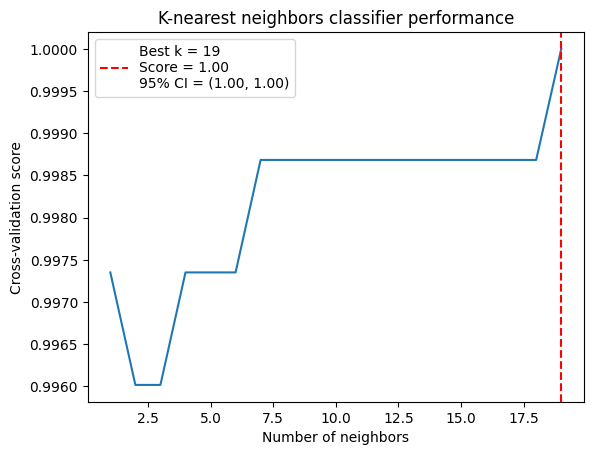

In [347]:
neighbors_range = range(1, 20)
cv_scores, best_k, best_score, lower_bound, upper_bound = trainWithKNNClassifier(neighbors_range)

label='Best k = %d\nScore = %0.2f\n95%% CI = (%0.2f, %0.2f)'
plot_hyperparameter(neighbors_range, cv_scores, best_k, best_score, lower_bound, upper_bound, 'K-nearest neighbors classifier performance', 'Number of neighbors', label)

results.append({
    CLASSIFIER: 'K-nearest neighbors',
    HYPERPARAMETER: 'Number of neighbors',
    BEST_HYPERPARAMETER: best_k,
    BEST_SCORE: best_score,
    LOWER_BOUND: lower_bound,
    UPPER_BOUND: upper_bound
})

#### Decision trees (max_depth)

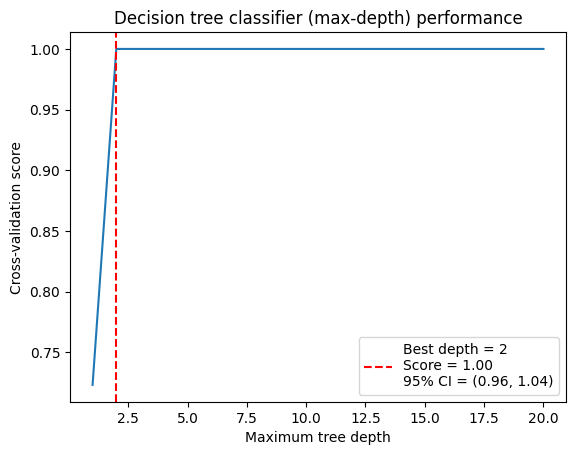

In [348]:
depth_range = range(1, 21)
cv_scores, best_depth, best_score, lower_bound, upper_bound = trainWithDecisionTreeClassifier(depth_range)

label='Best depth = %d\nScore = %0.2f\n95%% CI = (%0.2f, %0.2f)'
plot_hyperparameter(depth_range, cv_scores, best_depth, best_score, lower_bound, upper_bound, 'Decision tree classifier (max-depth) performance', 'Maximum tree depth', label)

results.append({
    CLASSIFIER: 'Decision tree',
    HYPERPARAMETER: 'Maximum tree depth',
    BEST_HYPERPARAMETER: best_depth,
    BEST_SCORE: best_score,
    LOWER_BOUND: lower_bound,
    UPPER_BOUND: upper_bound
})

#### Perceptron

C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\Administrateur\A

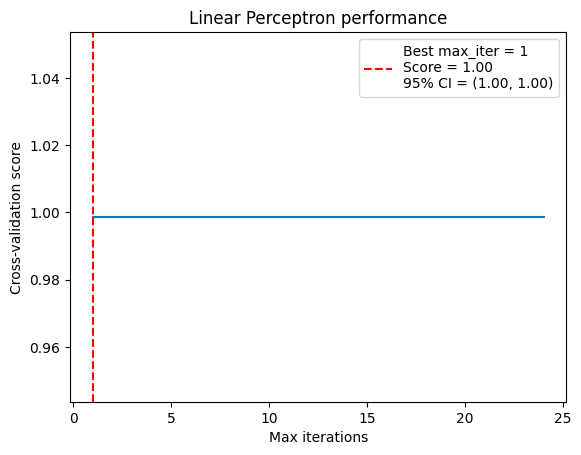

In [349]:
# Define the range of values for the hyperparameter to tune
max_iters = range(1, 25)
cv_scores, best_max_iter, best_score, lower_bound, upper_bound = trainWithPerceptron(max_iters)

label='Best max_iter = %d\nScore = %0.2f\n95%% CI = (%0.2f, %0.2f)'
plot_hyperparameter(max_iters, cv_scores, best_max_iter, best_score, lower_bound, upper_bound, 'Linear Perceptron performance', 'Max iterations', label)

results.append({
    CLASSIFIER: 'Linear perceptron',
    HYPERPARAMETER: 'Max iterations',
    BEST_HYPERPARAMETER: best_max_iter,
    BEST_SCORE: best_score,
    LOWER_BOUND: lower_bound,
    UPPER_BOUND: upper_bound
})

#### SVC Gaussian

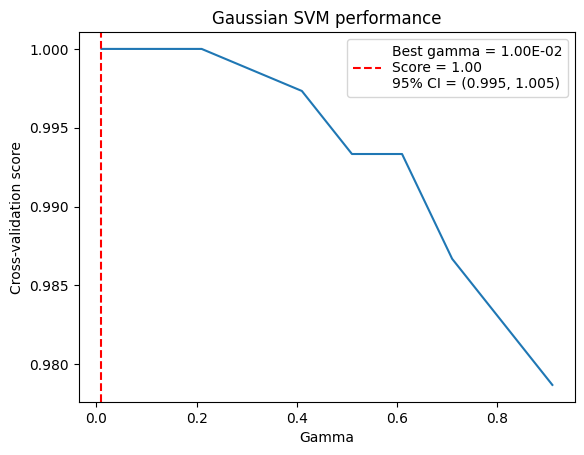

In [350]:
# Define the range of values for the hyperparameter to tune
gammas = np.arange(0.01, 1, 0.1)
cv_scores, best_gamma, best_score, lower_bound, upper_bound = trainWithSVCGaussian(gammas)

label='Best gamma = %0.2E\nScore = %0.2f\n95%% CI = (%0.3f, %0.3f)'
plot_hyperparameter(gammas, cv_scores, best_gamma, best_score, lower_bound, upper_bound, 'Gaussian SVM performance', 'Gamma', label)

results.append({
    CLASSIFIER: 'Gaussian SVM',
    HYPERPARAMETER: 'Gamma',
    BEST_HYPERPARAMETER: best_gamma,
    BEST_SCORE: best_score,
    LOWER_BOUND: lower_bound,
    UPPER_BOUND: upper_bound
})

#### SVC Polynomial

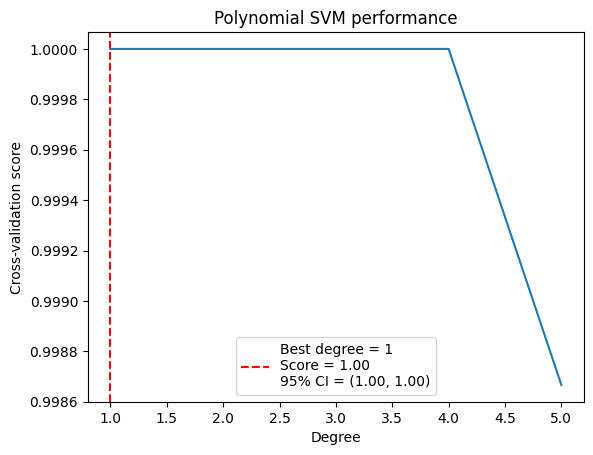

In [351]:
# Define the range of values for the hyperparameter to tune
degrees = range(1, 6)
cv_scores, best_degree, best_score, lower_bound, upper_bound = trainWithSVCPolynomial(degrees)

label='Best degree = %d\nScore = %0.2f\n95%% CI = (%0.2f, %0.2f)'
plot_hyperparameter(degrees, cv_scores, best_degree, best_score, lower_bound, upper_bound, 'Polynomial SVM performance', 'Degree', label)

results.append({
    CLASSIFIER: 'Polynomial SVM',
    HYPERPARAMETER: 'Degree',
    BEST_HYPERPARAMETER: best_degree,
    BEST_SCORE: best_score,
    LOWER_BOUND: lower_bound,
    UPPER_BOUND: upper_bound
})

#### MultinomialNB

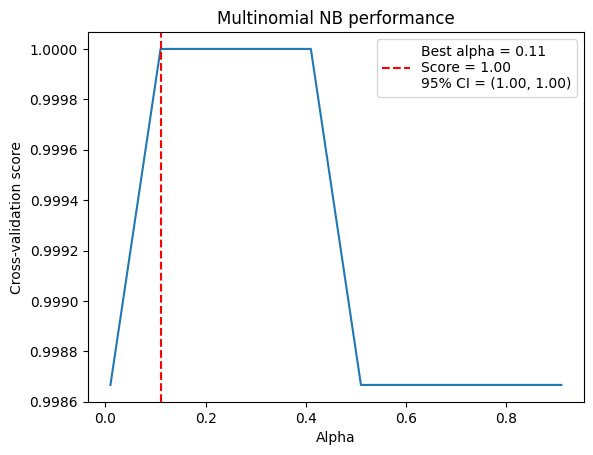

In [352]:
# Define the range of values for the hyperparameter to tune
alphas = np.arange(0.01, 1, 0.1)
cv_scores, best_alpha, best_score, lower_bound, upper_bound = trainWithMultinomialNB(alphas)

label='Best alpha = %0.2f\nScore = %0.2f\n95%% CI = (%0.2f, %0.2f)'
plot_hyperparameter(alphas, cv_scores, best_alpha, best_score, lower_bound, upper_bound, 'Multinomial NB performance', 'Alpha', label)

results.append({
    CLASSIFIER: 'Multinomial NB',
    HYPERPARAMETER: 'Alpha',
    BEST_HYPERPARAMETER: best_alpha,
    BEST_SCORE: best_score,
    LOWER_BOUND: lower_bound,
    UPPER_BOUND: upper_bound
})

---
### Overview
---

In [353]:
import pandas as pd
df = pd.DataFrame(results)

df_sorted = df.sort_values(by=BEST_SCORE, ascending=False)
df_sorted.head()

,Classifier,Hyperparameter,Best Hyperparameter,Best Score,Lower Bound,Upper Bound
0,K-nearest neighbors,Number of neighbors,19.00,1.0,0.998885,1.001115
1,Decision tree,Maximum tree depth,2.00,1.0,0.962587,1.037413
3,Gaussian SVM,Gamma,0.01,1.0,0.995406,1.004594
4,Polynomial SVM,Degree,1.00,1.0,0.999669,1.000331
5,Multinomial NB,Alpha,0.11,1.0,0.999595,1.000405


## Classification

#### K-nearest neighbors

In [354]:
def classifyWithKNeighborsClassifier(X_test):
    best_hyperparam = df.loc[df[CLASSIFIER] == 'K-nearest neighbors', BEST_HYPERPARAMETER].iloc[0]

    knn = KNeighborsClassifier(n_neighbors=int(best_hyperparam))
    knn.fit(X_train, Y_train)

    Y_pred = knn.predict(X_test)
    return Y_pred

#### Decision trees (max_depth)

In [355]:
def classifyWithDecisionTreeClassifier(X_test):
    best_hyperparam = df.loc[df[CLASSIFIER] == 'Decision tree', BEST_HYPERPARAMETER].iloc[0]

    dt = DecisionTreeClassifier(max_depth=int(best_hyperparam), random_state=42)
    dt.fit(X_train, Y_train)

    Y_pred = dt.predict(X_test)
    return Y_pred

#### Perceptron

In [356]:
def classifyWithPerceptron(X_test):
    best_hyperparam = df.loc[df[CLASSIFIER] == 'Linear perceptron', BEST_HYPERPARAMETER].iloc[0]

    perceptron = Perceptron(max_iter=int(best_hyperparam))
    perceptron.fit(X_train, Y_train)

    Y_pred = perceptron.predict(X_test)
    return Y_pred

#### SVC Gaussian

In [357]:
def classifyWithSVCGaussian(X_test):
    best_hyperparam = df.loc[df[CLASSIFIER] == 'Gaussian SVM', BEST_HYPERPARAMETER].iloc[0]

    svm = SVC(kernel='rbf', gamma=best_hyperparam)
    svm.fit(X_train, Y_train)

    Y_pred = svm.predict(X_test)
    return Y_pred

#### SVC Polynomial

In [358]:
def classifyWithSVCPolynomial(X_test):    
    best_hyperparam = df.loc[df[CLASSIFIER] == 'Polynomial SVM', BEST_HYPERPARAMETER].iloc[0]

    svm = SVC(kernel='poly', degree=int(best_hyperparam))
    svm.fit(X_train, Y_train)

    Y_pred = svm.predict(X_test)
    return Y_pred

#### MultinomialNB

In [359]:
def classifyWithMultinomialNB(X_test):    
    best_hyperparam = df.loc[df[CLASSIFIER] == 'Multinomial NB', BEST_HYPERPARAMETER].iloc[0]

    mnb = MultinomialNB(alpha=best_hyperparam)
    mnb.fit(X_train, Y_train)

    Y_pred = mnb.predict(X_test)
    return Y_pred

### Classification results

Let's write a function to display the predicted labels of the monuments tests set and display them with their name and categories.

In [360]:
import plotly.graph_objects as go
import plotly.express as px

def show_monuments_by_label(Y_pred, X_test):
    # Create a list of monument names
    monuments = vectorizer.inverse_transform(X_test)
    names = [', '.join(m) for m in monuments]

    # Create a data frame with the monument names, their predicted labels, and their index in the test set
    df = pd.DataFrame({'Monument': names, 'Label': Y_pred, 'Index': list(range(X_test.shape[0]))})

    # Create a dictionary to map labels to colors
    label_to_color = {label: color for label, color in zip(df['Label'].unique(), px.colors.qualitative.Dark24)}

    # Create a trace for each label
    traces = []
    for label, color in label_to_color.items():
        mask = df['Label'] == label
        traces.append(go.Scatter(x=df.loc[mask, 'Index'], y=[label] * mask.sum(),
                                 mode='markers',
                                 text=df.loc[mask, 'Monument'],
                                 hovertemplate='%{text}',
                                 marker=dict(size=10, color=color),
                                 name='Label {}'.format(label)))

    # Set the plot title and axis labels
    layout = go.Layout(title='Monument Labels',
                       xaxis_title='Monument Index',
                       yaxis_title='Predicted Label')

    # Create the figure and show the plot
    fig = go.Figure(data=traces, layout=layout)
    fig.show()

We will also define a function to evaluate the performance of our models.

In [361]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_classification_model(Y_pred):
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='weighted')
    f1 = f1_score(Y_test, Y_pred, average='weighted')
    
    # Print evaluation metrics
    print("Accuracy: {:.2f}".format(accuracy))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1-score: {:.2f}".format(f1))


In [362]:
from IPython.display import display

def display_dataframe_monuments(Y_pred):
    # Create a list of monument names and their predicted labels
    monuments = vectorizer.inverse_transform(X_test)
    names = [', '.join(m) for m in monuments]
    df = pd.DataFrame({'Monument': names, 'Label': Y_pred})

    # Sort the data frame by the "Label" column
    df_sorted = df.sort_values(by="Label")
    df_sorted.to_csv('monuments.csv', index=False)

    # Display the sorted data frame
    display(df_sorted)

#### K-nearest neighbors

In [363]:
Y_pred = classifyWithKNeighborsClassifier(X_test)
evaluate_classification_model(Y_pred)
display_dataframe_monuments(Y_pred)
show_monuments_by_label(Y_pred, X_test)

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


,Monument,Label
1392,chateau,0
511,chateau,0
512,"ancien, chateau",0
513,chateau,0
514,chateau,0
...,...,...
884,"chateau, dite, maison",2
890,"maison, rempart",2
901,maison,2
904,maison,2


#### Decision trees (max_depth)

In [364]:
Y_pred = classifyWithDecisionTreeClassifier(X_test)
evaluate_classification_model(Y_pred)
show_monuments_by_label(Y_pred, X_test)

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


#### Perceptron

In [365]:
Y_pred = classifyWithPerceptron(X_test)
evaluate_classification_model(Y_pred)
show_monuments_by_label(Y_pred, X_test)

C:\Users\Administrateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


#### SVC Gaussian

In [366]:
Y_pred = classifyWithSVCGaussian(X_test)
evaluate_classification_model(Y_pred)
show_monuments_by_label(Y_pred, X_test)

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


#### SVC Polynomial

In [367]:
Y_pred = classifyWithSVCPolynomial(X_test)
evaluate_classification_model(Y_pred)
show_monuments_by_label(Y_pred, X_test)

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


#### MultinomialNB

In [368]:
Y_pred = classifyWithMultinomialNB(X_test)
evaluate_classification_model(Y_pred)
show_monuments_by_label(Y_pred, X_test)

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00
